In [1]:
!git clone https://github.com/sameerpixelbot/Anomaly_Transformer.git

Cloning into 'Anomaly_Transformer'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 42 (delta 23), reused 33 (delta 14), pack-reused 0
Unpacking objects: 100% (42/42), done.


In [2]:
cd Anomaly_Transformer/

/content/Anomaly_Transformer


In [3]:
from transformer import Transformer
import pandas as pd

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

In [5]:
num_layers=6
d_model=128
num_heads=8
num_parts=4
dff=128
target_size=128
num_of_outputs=7

In [6]:
if((d_model//num_heads)%num_parts==0):
  trans=Transformer(num_layers=num_layers,d_model=d_model,num_heads=num_heads,num_parts=num_parts,dff=dff,target_size=target_size,num_of_outputs=num_of_outputs)
else:
  print('Dimensions do not match')

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False,name='loss_object')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  
  #loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

  # train_loss.update_state(real,pred)
  # loss=train_loss.result()
  # return loss

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

In [ ]:
EPOCHS = 200

In [ ]:
train_step_signature = [
    tf.TensorSpec(shape=(15,34), dtype=tf.float32),
    tf.TensorSpec(shape=(1,7), dtype=tf.float32),
]


def train_step(inp, tar):
  
  with tf.GradientTape() as tape:
    predictions, _ = trans(inp, True)
    #predictions=predictions[0]
    #print(predictions)
    loss = loss_function(tar, predictions)
    # train_loss.update_state(tar,predictions)
    # loss=train_loss.result()
    #print(loss)
  gradients = tape.gradient(loss, trans.trainable_variables)
  
  optimizer.apply_gradients(zip(gradients, trans.trainable_variables))
  
  train_loss(loss)
  # a=accuracy_function(tar, predictions)
  # print(a)
  train_accuracy.update_state(tar,predictions)

tf.function(func=train_step, input_signature=train_step_signature)

In [10]:
df=pd.read_csv('/content/gdrive/MyDrive/data1.csv',header=None)
#df=df.iloc[:500]
test=df[(df[45]==1) | (df[46]==1) | (df[64]==1) | (df[78]==1) | (df[79]==1) | (df[80]==1) | (df[85]==1)]
test2=test[[45,46,64,78,79,80,85]]
# df=df.iloc[::3,:].reset_index().drop('index',axis=1)
# test2=df.iloc[:,38:]
from sklearn.preprocessing import MinMaxScaler
scale=MinMaxScaler()
b=scale.fit_transform(test.iloc[:,4:38])
# b=scale.fit_transform(df.iloc[:,4:38])
temp=pd.DataFrame(b)
temp.insert(34,34,test[1].reset_index()[1])
temp=temp.join(test2.reset_index().drop('index',axis=1))
group_list=[]
for groups in temp.groupby(34):
    group_list.append(pd.DataFrame(groups[1]))
padding=pd.DataFrame(np.zeros((1,len(temp.iloc[0]))),columns=temp.columns)
threshold=15
x_train=[]
for group in group_list:
    if threshold<len(group[0]):
        x_train.append(group[-1*threshold:])
        continue
    for i in range(len(group[0]),threshold):
      group=group.append(padding,ignore_index=True) 
    x_train.append(group)
x_train_final=[]
y_train=[]
for i in range(1,len(x_train)):
  x_train_temp=tf.constant(x_train[i].iloc[:,:34].values,shape=(15,34),dtype='float32')
  x_train_final.append(x_train_temp)
  y_train_temp=tf.constant(x_train[i].iloc[:,-7:].iloc[0].values,shape=(1,7),dtype='float32')
  y_train.append(y_train_temp)

In [11]:
df=pd.read_csv('/content/gdrive/MyDrive/data6.csv',header=None)
#df=df.iloc[:500]
test=df[(df[45]==1) | (df[46]==1) | (df[64]==1) | (df[78]==1) | (df[79]==1) | (df[80]==1) | (df[85]==1)]
test2=test[[45,46,64,78,79,80,85]]
# df=df.iloc[::3,:].reset_index().drop('index',axis=1)
# test2=df.iloc[:,38:]
#from sklearn.preprocessing import MinMaxScaler
#scale=MinMaxScaler()
b=scale.transform(test.iloc[:,4:38])
# b=scale.fit_transform(df.iloc[:,4:38])
temp=pd.DataFrame(b)
temp.insert(34,34,test[1].reset_index()[1])
temp=temp.join(test2.reset_index().drop('index',axis=1))
group_list=[]
for groups in temp.groupby(34):
    group_list.append(pd.DataFrame(groups[1]))
padding=pd.DataFrame(np.zeros((1,len(temp.iloc[0]))),columns=temp.columns)
threshold=15
x_train=[]
for group in group_list:
    if threshold<len(group[0]):
        x_train.append(group[-1*threshold:])
        continue
    for i in range(len(group[0]),threshold):
      group=group.append(padding,ignore_index=True) 
    x_train.append(group)
x_train_final=[]
y_train=[]
for i in range(1,len(x_train)):
  x_train_temp=tf.constant(x_train[i].iloc[:,:34].values,shape=(15,34),dtype='float32')
  x_train_final.append(x_train_temp)
  y_train_temp=tf.constant(x_train[i].iloc[:,-7:].iloc[0].values,shape=(1,7),dtype='float32')
  y_train.append(y_train_temp)

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  i=0
  while i<len(y_train):
    
    inp=x_train_final[i]
    tar=y_train[i]

    i+=1
    # print(tar)
    train_step(inp, tar)
    batch=i
    if batch % 60 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
      
  # if (epoch + 1) % 2 == 0:
  #   ckpt_save_path = ckpt_manager.save()
  #   #trans.save(f'/content/gdrive/MyDrive/transformer/Transformer_{epoch+1}.h5')
  #   print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
    
  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 60 Loss 0.1808 Accuracy 0.9500
Epoch 1 Batch 120 Loss 0.1002 Accuracy 0.9667


KeyboardInterrupt: ignored

In [ ]:
trans.save_weights('/content/gdrive/MyDrive/datasets/model2.tf',save_format='tf')

In [12]:
trans.load_weights('/content/gdrive/MyDrive/datasets/model2.tf')

In [ ]:
len(y_train)

713

In [ ]:
temp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,45,46,64,78,79,80,85
0,0.555295,0.310850,0.499739,0.293769,0.559715,0.301075,0.570000,0.298387,0.554557,0.278455,0.589007,0.264172,0.603236,0.287162,0.607422,0.364444,0.594301,0.348066,0.518016,0.503421,0.557927,0.485826,0.594194,0.247467,0.572226,0.236842,0.558457,0.292962,0.596141,0.197026,0.570104,0.638655,0.495717,0.632075,8,1,0,0,0,0,0,0
1,0.555881,0.311828,0.500261,0.293769,0.560309,0.301075,0.570588,0.298387,0.555199,0.279472,0.589007,0.264172,0.603236,0.287162,0.608073,0.363333,0.593623,0.350276,0.518016,0.503421,0.557927,0.485826,0.594194,0.250362,0.572226,0.238304,0.558457,0.294599,0.596141,0.198885,0.570684,0.638655,0.495717,0.632075,8,1,0,0,0,0,0,0
2,0.555881,0.310850,0.500782,0.293769,0.560309,0.301075,0.570000,0.298387,0.555199,0.278455,0.589007,0.264172,0.603236,0.287162,0.607422,0.363333,0.593623,0.349171,0.517493,0.504399,0.557927,0.485826,0.594194,0.248915,0.572226,0.238304,0.558457,0.294599,0.596141,0.198885,0.570684,0.638655,0.495717,0.631027,8,1,0,0,0,0,0,0
3,0.555295,0.309873,0.500261,0.292779,0.559715,0.301075,0.570000,0.298387,0.555199,0.278455,0.589007,0.263039,0.603883,0.287162,0.608073,0.362222,0.594301,0.350276,0.515927,0.503421,0.558537,0.485826,0.595484,0.246020,0.573466,0.235380,0.558457,0.291326,0.596141,0.197026,0.570684,0.638655,0.495182,0.632075,8,1,0,0,0,0,0,0
4,0.552955,0.310850,0.498176,0.293769,0.557932,0.302053,0.568235,0.298387,0.551990,0.280488,0.588382,0.264172,0.603883,0.289414,0.610026,0.361111,0.595658,0.351381,0.515405,0.502444,0.563415,0.485826,0.600645,0.243126,0.579045,0.233918,0.557270,0.284779,0.596785,0.187732,0.570684,0.636555,0.495717,0.629979,8,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13112,0.608543,0.367546,0.543512,0.349159,0.616756,0.351906,0.573529,0.278226,0.592426,0.303862,0.532792,0.226757,0.605825,0.345721,0.606120,0.242222,0.576662,0.488398,0.503394,0.347996,0.541463,0.651026,0.505806,0.344428,0.533168,0.391813,0.528783,0.464812,0.549839,0.509294,0.529548,0.792017,0.461456,0.879455,6108,0,0,0,0,0,0,1
13113,0.588648,0.321603,0.529442,0.297725,0.591800,0.304008,0.596471,0.299395,0.559692,0.265244,0.523423,0.224490,0.595469,0.329955,0.529948,0.353333,0.584803,0.472928,0.485117,0.462366,0.570122,0.639296,0.524516,0.366136,0.533788,0.383041,0.520475,0.490998,0.552412,0.501859,0.528969,0.796218,0.460921,0.878407,6108,0,0,0,0,0,0,1
13114,0.588648,0.321603,0.529442,0.297725,0.591800,0.304008,0.596471,0.299395,0.559692,0.265244,0.523423,0.224490,0.595469,0.329955,0.529948,0.353333,0.584803,0.472928,0.485117,0.462366,0.570122,0.639296,0.524516,0.366136,0.533788,0.383041,0.520475,0.476268,0.552412,0.501859,0.528969,0.796218,0.460921,0.878407,6108,0,0,0,0,0,0,1
13115,0.566998,0.292278,0.510683,0.266073,0.565062,0.277615,0.577059,0.254032,0.535302,0.244919,0.540912,0.244898,0.575405,0.302928,0.546224,0.353333,0.576662,0.451934,0.493995,0.478006,0.584756,0.610948,0.554839,0.373372,0.539988,0.383041,0.522255,0.492635,0.554341,0.500000,0.527810,0.798319,0.460921,0.879455,6108,0,0,0,0,0,0,1


In [ ]:
len(temp)/15

874.4666666666667

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [13]:
y_pred=[]
for inp in x_train_final:
  
  pred,_=trans(inp,False)
  y_pred.append(pred)

In [15]:
from sklearn.metrics import classification_report,confusion_matrix

In [14]:
def points(y_value):
    index=0
    m=-99999
    for i in range(len(y_value[0])):
      if y_value[0][i].numpy()>m:
        index=i
        m=y_value[0][i].numpy()
    return index

In [16]:
y_pred_final=list(map(points,y_pred))

In [17]:
y_true_final=list(map(points,y_train))

In [18]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


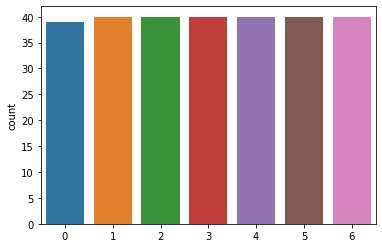

In [19]:
sns.countplot(y_true_final)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


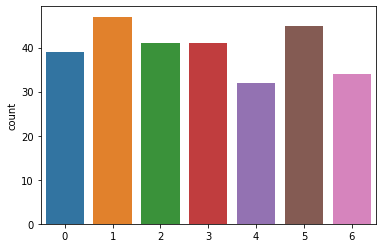

In [20]:
sns.countplot(y_pred_final)

In [21]:
print(classification_report(y_true_final,y_pred_final))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        39
           1       0.83      0.97      0.90        40
           2       0.95      0.97      0.96        40
           3       0.78      0.80      0.79        40
           4       0.97      0.78      0.86        40
           5       0.89      1.00      0.94        40
           6       0.76      0.65      0.70        40

    accuracy                           0.87       279
   macro avg       0.88      0.87      0.87       279
weighted avg       0.88      0.87      0.87       279

